## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os 
import preprocessingV1
import visualization
from utils import generate_signal_dictionary
path = os.getcwd()

## DATA PREPROCESSING

We read all the data, split them into 2 subsets of training and testing data. 

In [2]:
import random
from random import sample
# ========================================================================
signal_16zt = preprocessingV1.get_filename('16zt')
signal_8zt = preprocessingV1.get_filename('8zt')
signal_0zt = preprocessingV1.get_filename('0zt')

random.seed(10)

# 16zt =====================================================================
test_idx_16zt = sample(range(1,len(signal_16zt)),5)
# train_idx_16zt = list(set(np.arange(1,len(signal_16zt)))-set(test_idx_16zt))
train_idx_16zt = sample(range(1,len(signal_16zt)),3)
# 8zt =====================================================================
test_idx_8zt = sample(range(1,len(signal_8zt)),5)
# train_idx_8zt = list(set(np.arange(1,len(signal_8zt)))-set(test_idx_8zt))
train_idx_8zt = sample(range(1,len(signal_8zt)),3)
# 0zt =====================================================================
test_idx_0zt = sample(range(1,len(signal_0zt)),5)
# train_idx_0zt = list(set(np.arange(1,len(signal_0zt)))-set(test_idx_0zt))
train_idx_0zt = sample(range(1,len(signal_0zt)),3)

# test_idx_0zt = [1]
# train_idx_0zt = [0]

name_dict = {'16zt': (signal_16zt[train_idx_16zt], signal_16zt[test_idx_16zt]),
             '8zt': (signal_8zt[train_idx_8zt], signal_8zt[test_idx_8zt]),
             '0zt': (signal_0zt[train_idx_0zt], signal_0zt[test_idx_0zt])}

In [3]:
data = {}; data_test = {}
name = ['0zt','8zt','16zt']
for n in name:
    data, data_test = generate_signal_dictionary(data, data_test,outlier_filter=True, name_dict = name_dict, name=n)

## Reading and preprocessing data

I reckon that there are many unusual peaks in the signals, so I decided to filter out the values which are outside of [Q1-1.5IQR,Q3+1.5IQR] (i.e., the usual statistical definition for outliers). 

Next, I perform 4 scaling strategies on the signals: None, by MinMax, by mean and std, and partially by mean and std. The last option will consider each waveform individually before scaling instead of scaling the whole signals.

In [4]:
window_size = 1024
df, label = preprocessingV1.generate_model_data(data_dictionary=data,mode = 'mlp',scale = None,window_size = window_size,verbose = True)

binary_label = []
for i in range(len(label)):
    if label[i] == 'e2':
        binary_label.append(3)
    else:
        binary_label.append('c')

Mode: mlp
Scale option: None
Model data shape: (100008, 513), label shape: (100008,)
Class distribution:  (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2436, 10544,  9873, 60011,  8354,  2287,  6503], dtype=int64))
Class encoding:  {'np': 0, 'c': 1, 'e1': 2, 'e2': 3, 'f': 4, 'pd': 5, 'g': 6}


In [5]:
df_test, label_test = preprocessingV1.generate_model_data(data_dictionary=data_test,mode = 'mlp',scale = None,window_size = window_size,verbose = True)

binary_label_test = []
for i in range(len(label_test)):
    if label_test[i] == 'e2':
        binary_label_test.append(1)
    else:
        binary_label_test.append(-1)

Mode: mlp
Scale option: None
Model data shape: (166336, 513), label shape: (166336,)
Class distribution:  (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 17997,  19604,   4680, 100705,  12982,   5110,   5258],
      dtype=int64))
Class encoding:  {'np': 0, 'c': 1, 'e1': 2, 'e2': 3, 'f': 4, 'pd': 5, 'g': 6}


In [6]:
X = df, label
y = df_test, label_test

# MLP MODEL 

For this work, I tried using an MLP model consisting of 3 fully connected layers, reLU activation and dropout layers with probability 0.3 in between. 

By empirical study, I found that these parameters are suitable for my project. Batch normalization was also introduced but it does not improve the performance.

In [8]:
from models import MLP
from DataGeneratorV0 import get_loader
import implementV0

The performance of the MLP model is quite good with almost 90% accuracy and 80% balanced accuracy. It can be found that the scaling strategies does make some improvement in specific cases, so we may relies on combining several MLP models with different scaling strategies for better prediction result. 

In [ ]:
device = 'cuda'

n_classes = len(preprocessingV1.labels_dict)
input_size = df.shape[1]

num_epochs = 50
learning_rate = 0.0001

MLP_scale_trainloss = {}
MLP_scale_validationacc = {}
MLP_scale_classaccuracy = {}
MLP_scale_testscore = {}
MLP_scale_testcf = {}

scale = [None]
for s in scale:
    print(f'================ Scale strategy: {s} ================')
    train_loader, validation_loader, test_loader = get_loader(X,y,mode = 'mlp')
    model = MLP(input_size,n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    train_loss = []
    validation_accuracy = []
    class_accuracy = []
    test_score = []
    test_confusion_matrix = []

    for epoch in range(num_epochs):
        
        implementV0.train_one_epoch(model,device,optimizer,criterion,train_loader,train_loss)
        implementV0.validate_one_epoch(model,device,validation_loader,validation_accuracy)

        if (epoch %10 == 0) or (epoch == num_epochs - 1):
            print(f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss[epoch]:.4f}, validation accuracy: {validation_accuracy[epoch]:.4f}')  

    implementV0.test(model,device,label_test,test_loader,test_score,class_accuracy,test_confusion_matrix)
    
    MLP_scale_trainloss[s] = train_loss
    MLP_scale_validationacc[s]  = validation_accuracy
    MLP_scale_classaccuracy[s]  = class_accuracy
    MLP_scale_testscore[s]  = test_score
    MLP_scale_testcf[s]  = test_confusion_matrix


================ Scale strategy: None ================
Train, validate, test lengths: (412794, 176913, 168638)
Input shape: torch.Size([32, 513])
Epoch [1/50], loss: 0.4993, validation accuracy: 0.9326
Epoch [11/50], loss: 0.1520, validation accuracy: 0.9587
Epoch [21/50], loss: 0.1358, validation accuracy: 0.9618
Epoch [31/50], loss: 0.1284, validation accuracy: 0.9639
Epoch [41/50], loss: 0.1225, validation accuracy: 0.9639
Epoch [50/50], loss: 0.1188, validation accuracy: 0.9653
Accuracy : 0.9258
Balanced accuracy: 0.8651
Predicted labels: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([10603, 21914,  6756, 97739, 14836,  6818,  9972], dtype=int64))
True labels: (array([0, 1, 2, 3, 4, 5, 6]), array([ 9886, 21046,  5873, 97593, 16118,  6827, 11295], dtype=int64))



In [24]:
torch.save(model.state_dict(),'MLP state_dict checkpoint.pth')

For demonstration, we plot the original and the prediction result side by side. 

It can be seen that our model did pretty well in predicting long waveforms but the performance on short and sudden waveforms like "pd" is not as good. 

Most of the time the short waves are mistaken but the mistake can be understand due to the similarities in terms of Fourier transform coefficients between waves. 

It can detect the start and the end of the waveforms (with some errors).

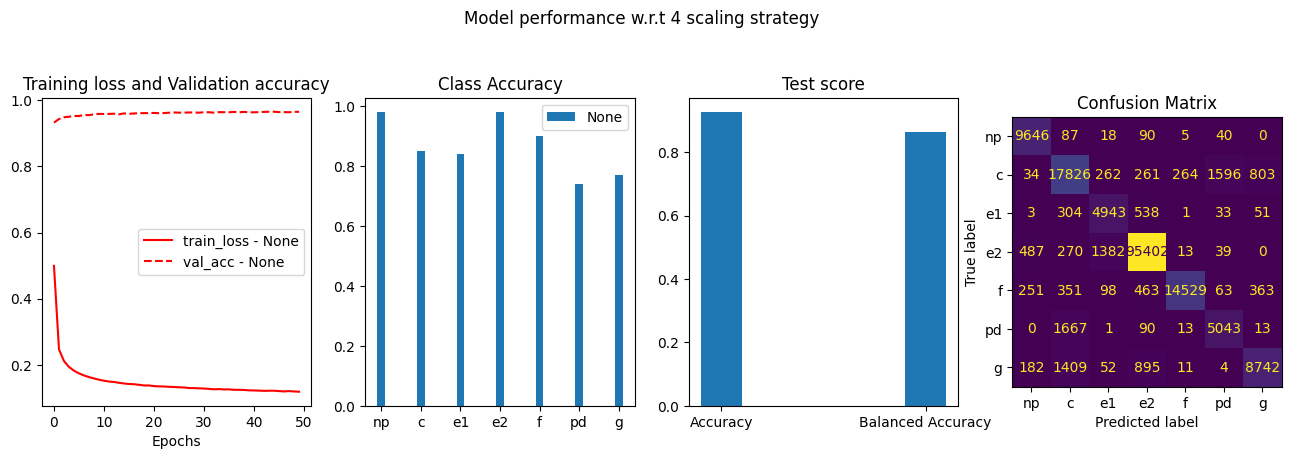

In [10]:
implementV0.plot_test_result(scale,MLP_scale_trainloss, MLP_scale_validationacc, MLP_scale_classaccuracy, MLP_scale_testscore, MLP_scale_testcf)

In [9]:
n_classes = len(preprocessingV1.labels_dict)
input_size = df.shape[1]

model = MLP(input_size,n_classes)
model.load_state_dict(torch.load('MLP state_dict checkpoint.pth'))

device = 'cpu'

In [10]:
import matplotlib.pyplot as plt

In [19]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
def make_prediction(wave_array,ana,model,device,window_size=1024,hop_length=256,mode = 'mlp',scope = 5):

    # Prepare data
    input, true_label = preprocessingV1.generate_data(wave_array,ana,window_size=window_size,hop_length=hop_length,mode=mode)

    # Make dense prediction
    predicted_label = []
    for i in range(input.shape[0]):
        x = torch.from_numpy(input[i,:]).unsqueeze(0).float().to(device)
        prediction = torch.argmax(model(x),dim=1).cpu().item()
        predicted_label.append(prediction)
    
    print('Accuracy: ', round(accuracy_score(true_label,predicted_label),2))
    print('Balanced accuracy: ', round(balanced_accuracy_score(true_label,predicted_label),2))
    # return predicted_label    

    # ================ IN DEVELOPMENT ==================
    # # Inspect surrounding signals and follows major votes 
    # aggregation = predicted_label[0:3]
    # for i in range(3,len(predicted_label)):
    #     l, c = np.unique(predicted_label[i-3:i+1],return_counts=True)
    #     aggregation.append(l[np.argmax(c)])
    # predicted_label = aggregation
        
    # # Inspect surrounding signals and follows major votes
    # scope = 5    
    # for i in range(3,len(predicted_label)):
    #     left, right = int(np.floor(scope/2)), int(np.ceil(scope/2))
    #     l, c = np.unique(predicted_label[left:right],return_counts=True)
    #     corrected_label = l[np.argmax(c)]
    #     predicted_label[i] = corrected_label
    # # ===================================================
        
    # Write result in form of analysis files
    n_windows = input.shape[0]
    time = [] # Make time marks
    for i in range(n_windows):
        time.append((window_size+i*hop_length)/100)
    time = [0] + time 
    predicted_label = [predicted_label[0]] + predicted_label # merge the predicted labels
    
    predicted_label = pd.Series(predicted_label).map({0:1,1:2,2:4,3:5,4:6,5:8,6:7}).tolist()

    ana_label = [] # analysis file
    ana_time = [time[0]]

    pin = 0 # Merge consecutive commonly labeled intervals into one
    for i in range(n_windows):
        if predicted_label[i] != predicted_label[pin]:
            ana_label.append(predicted_label[pin])
            ana_time.append(time[i])
            pin = i
    ana_label.append(predicted_label[n_windows])

    ana_time.append(time[i])
    ana_label += [12]

    predicted_analysis = pd.DataFrame({'label':ana_label,'time':ana_time})
    
    return predicted_analysis
    

In [18]:
file = name_dict['0zt'][0][1]
wave_array,ana = data[file]
hop_length = 256
mode = 'mlp'
x_test,y_test = preprocessingV1.generate_data(wave_array,ana,window_size=1024,hop_length = hop_length, mode='mlp')

predicted_label = make_prediction(wave_array,ana,model,device,mode = 'mlp',hop_length=256)
from sklearn.metrics import accuracy_score,balanced_accuracy_score,confusion_matrix, ConfusionMatrixDisplay

print(balanced_accuracy_score(y_test,predicted_label),accuracy_score(y_test,predicted_label))
c = ConfusionMatrixDisplay(confusion_matrix(y_test,predicted_label),display_labels=np.unique(predicted_label))
c.plot()

Accuracy:  0.99
Balanced accuracy:  0.9
0.895901983255528 0.9937899219304471


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


array([[   73,     1,     0,    16,     0,     0,     0],
       [    1,   156,     0,     1,     0,    17,     2],
       [    0,     7,   128,     1,     1,     1,     9],
       [    0,     1,     3, 10746,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0],
       [    1,     8,     0,     0,     0,    99,     0],
       [    0,     0,     0,     0,     0,     0,     0]], dtype=int64)

Accuracy:  0.94
Balanced accuracy:  0.89


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


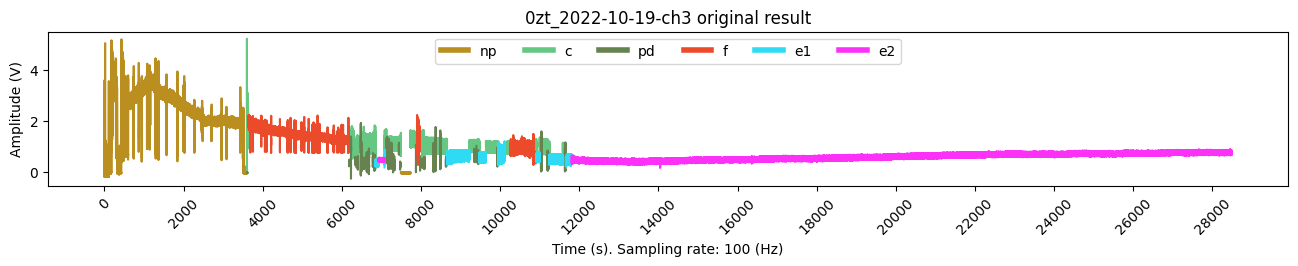

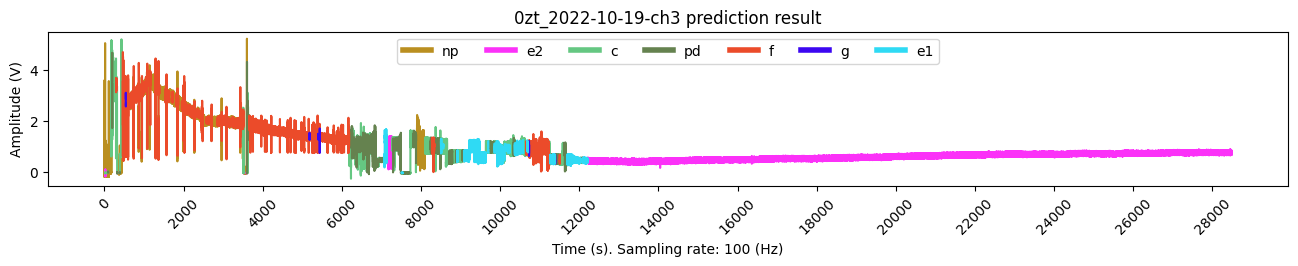

In [35]:
file = name_dict['0zt'][1][0]
wave_array,ana = data_test[file]

model.eval()
pred_ana = make_prediction(wave_array,ana,model,device,mode = 'mlp',hop_length=256)
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  1.0
Balanced accuracy:  0.92


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


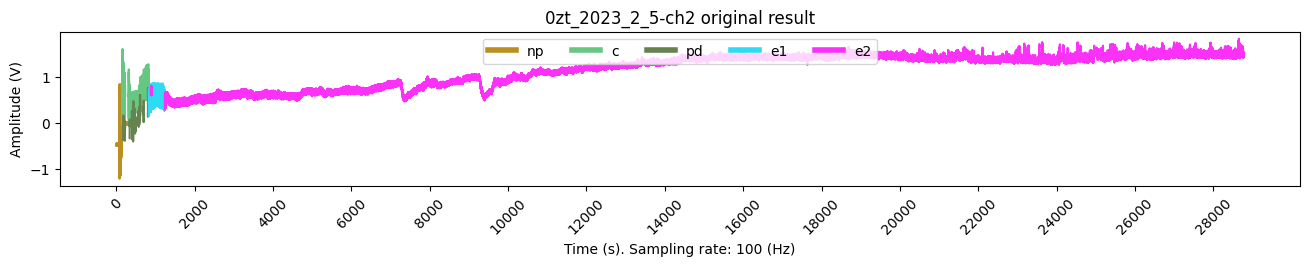

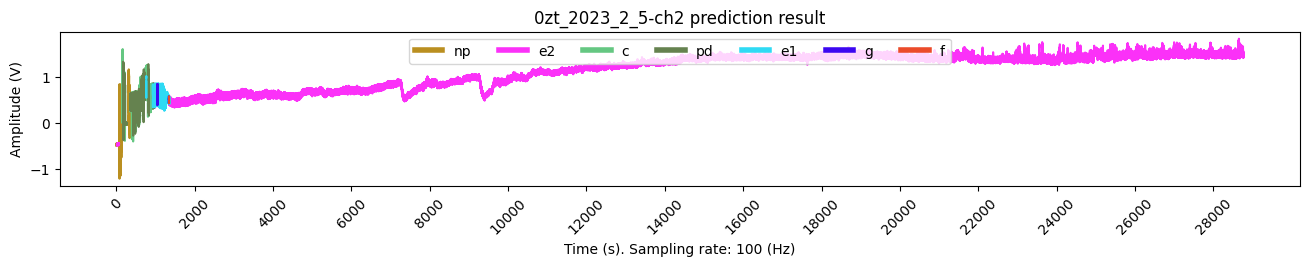

In [36]:
file = name_dict['0zt'][1][1]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'mlp')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.97
Balanced accuracy:  0.85


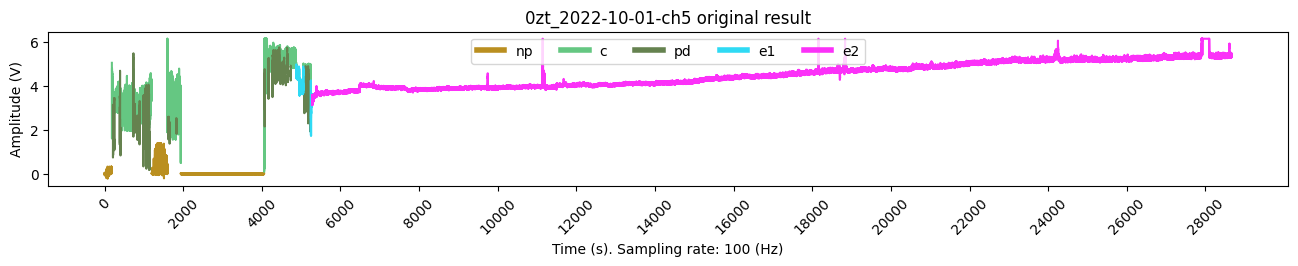

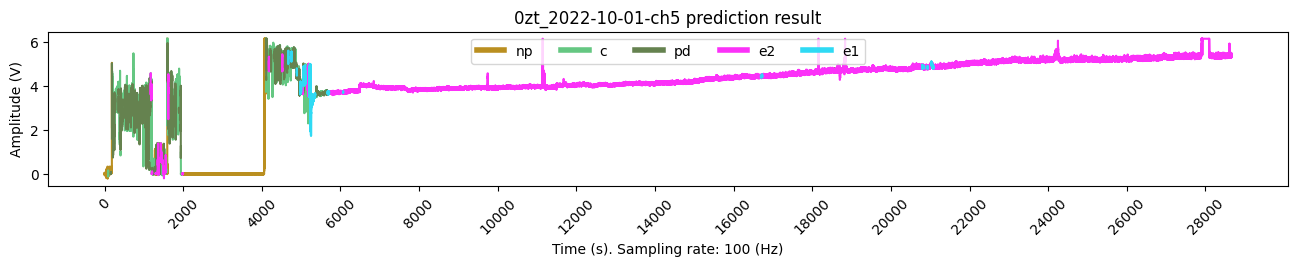

In [37]:
file = name_dict['0zt'][1][2]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'mlp')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.98
Balanced accuracy:  0.79


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


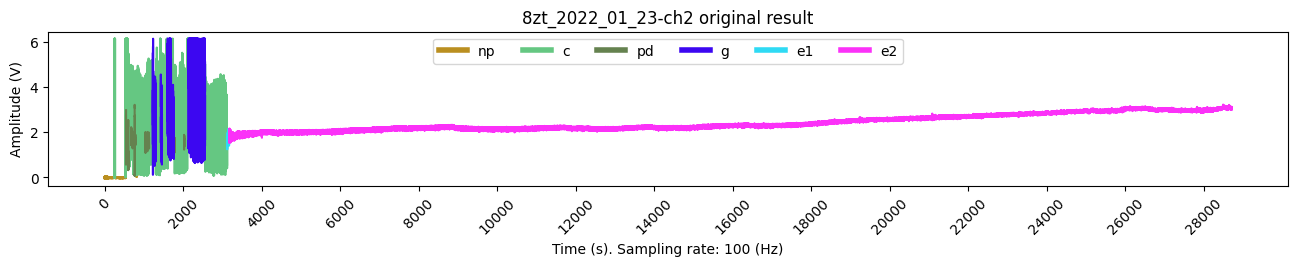

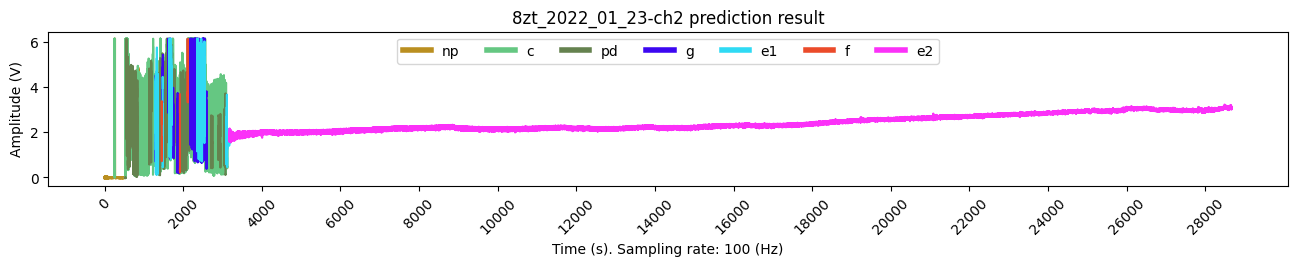

In [38]:
file = name_dict['8zt'][1][0]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'mlp')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.9
Balanced accuracy:  0.84


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


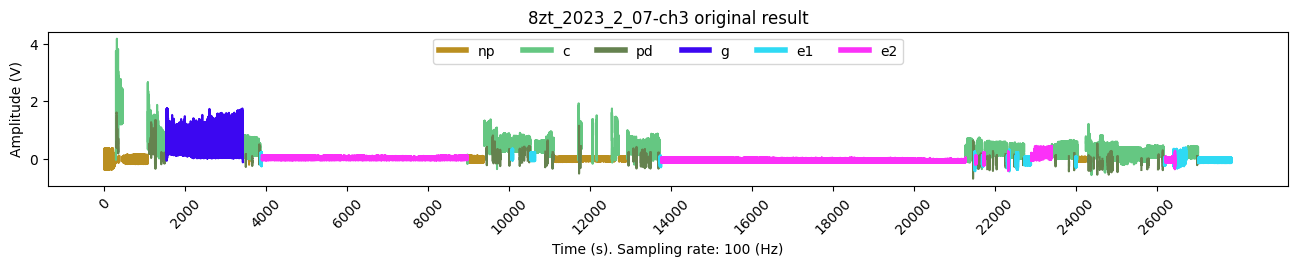

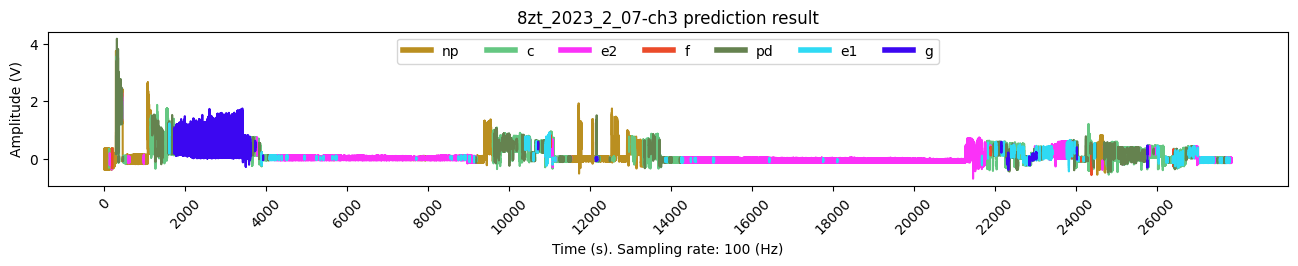

In [39]:
file = name_dict['8zt'][1][1]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'mlp')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.98
Balanced accuracy:  0.96


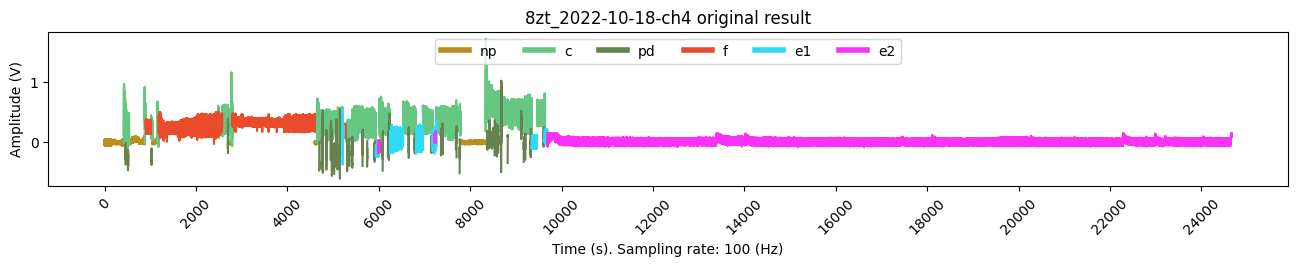

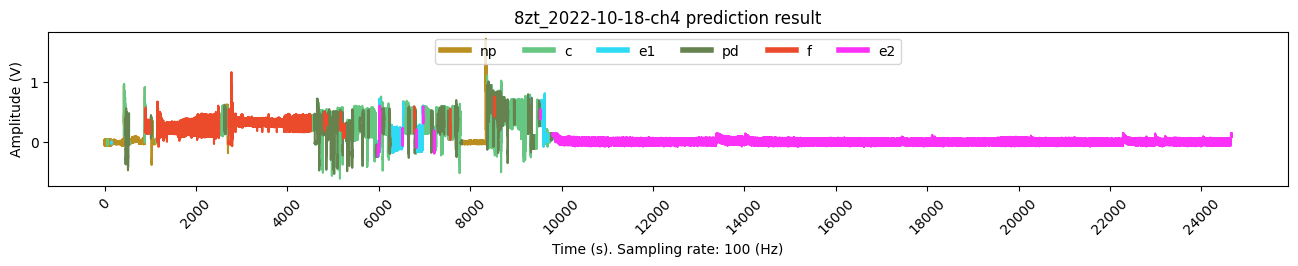

In [40]:
file = name_dict['8zt'][1][2]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'mlp')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.95
Balanced accuracy:  0.9


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


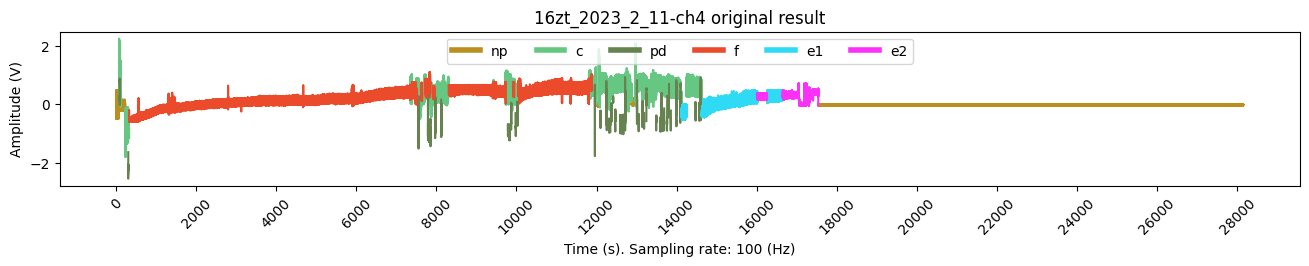

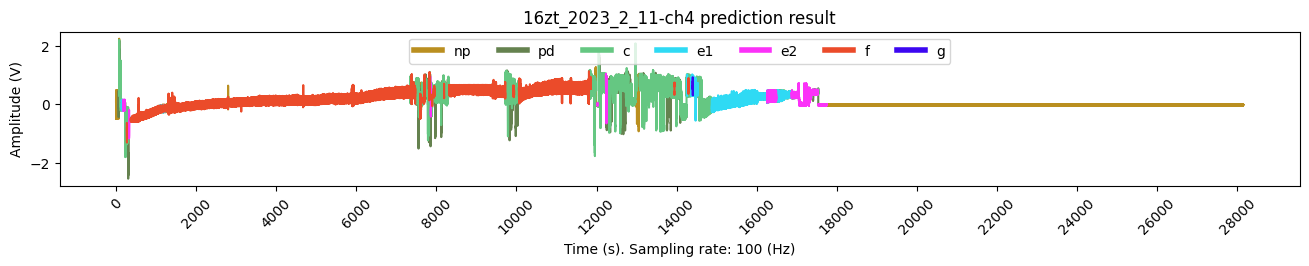

In [42]:
file = name_dict['16zt'][1][0]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'mlp')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.96
Balanced accuracy:  0.86


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


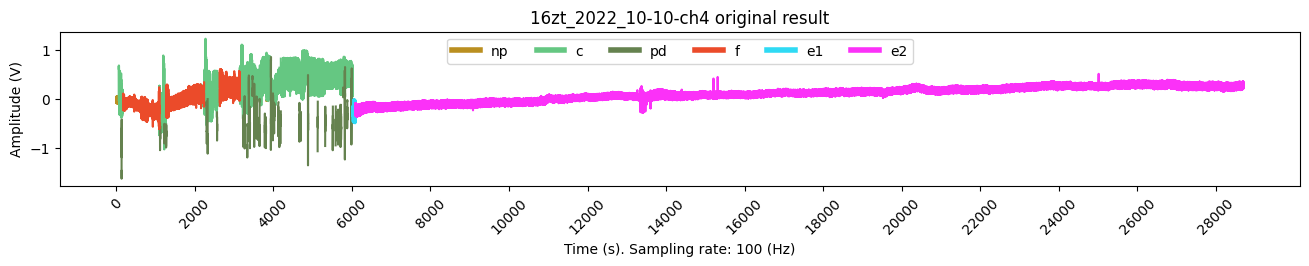

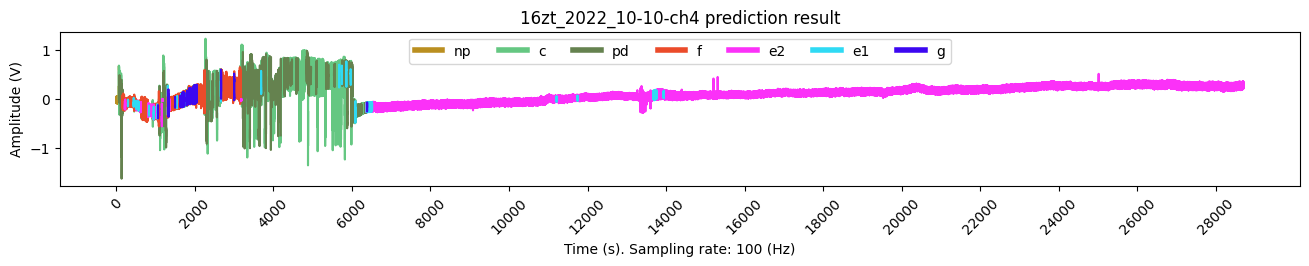

In [43]:
file = name_dict['16zt'][1][1]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'mlp')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.98
Balanced accuracy:  0.87


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


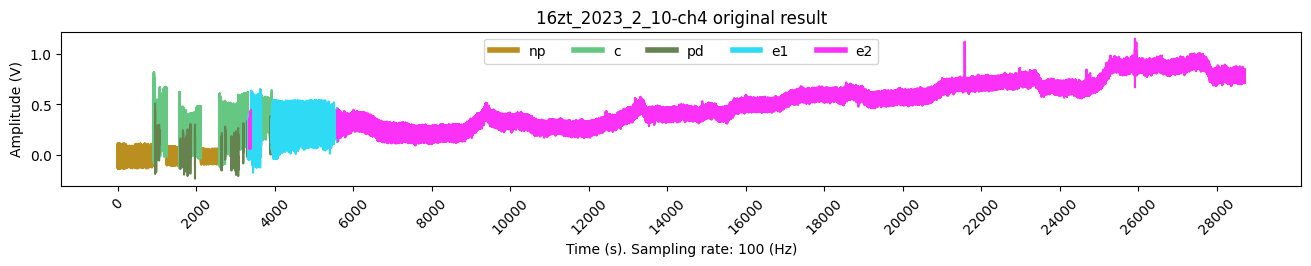

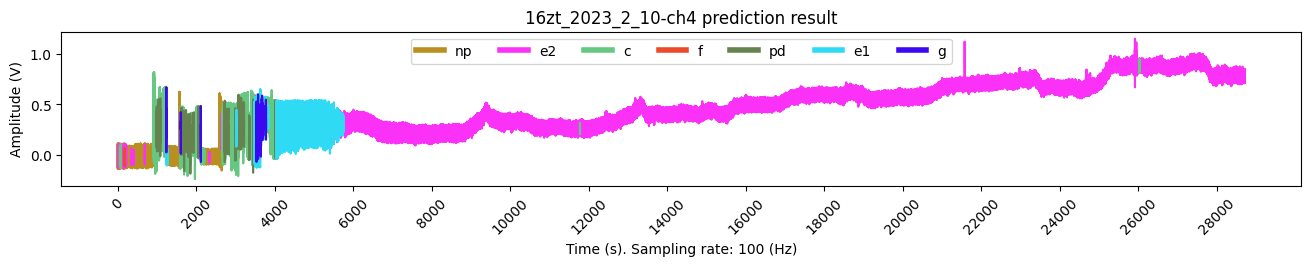

In [44]:
file = name_dict['16zt'][1][2]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'mlp')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

pred_ana.to_csv(f'{file}_P',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

# Final comment

Our model use direct fft coefficients as input and it has given pretty promising results.

However, there are many further things to improve

- Data augmentation: We could try to oversample the short and minor class such as 'pd' to emphasizes this behavior
- There are noises in the signals that has to be considered, for example: 'np' waves should looks like a flat line but there are instances that 'np' waves amplitudes fluctuate arond 1V
- Our model has not taken into account the relation between waveforms. For example, you can only find 'pd' waves in between pathway 'c' waves, or 'e1' is usually followed up by 'e2', ...